# Tarefa 1 - Implementação de KNN e PCA

Aluno: Tomás Aguiar Carneiro Ferreira

RA: 177748

In [209]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import time
from matplotlib import pyplot as plt

#Função que será utilizada para embaralhar os dados em termos da classificação
from sklearn.utils import shuffle 

#Função que utilizaremos para normalizar as features
from sklearn.preprocessing import StandardScaler

# Carregando o dataset Iris diretamente do scikit-learn
from sklearn.datasets import load_wine
wine = load_wine()

# Convertendo para um DataFrame do Pandas para facilitar a manipulação
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                    columns= wine['feature_names'] + ['target'])

# Convertendo para um array JAX se necessário para cálculos futuros
data_jax = jnp.array(data.values)

## 1. Preparo dos Dados

Antes de implementar qualquer algoritmo, vamos primeiramente estudar o dataset a ser utilizado.

In [2]:
#imprimir o shape de data
print(data.shape)

# Exibindo as primeiras linhas do DataFrame
print(data.head())

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0

Como podemos ver, os dados englobam vários tipos de vinhos diferentes - linhas do dataset -, os quais possuem diferentes atributos (ou 'features') - colunas do dataset. Além disso, o último atributo, o 'target' consiste numa classificação do vinho, cuja atribuição - pelo menos no momento - é desconhecida para nós.

In [3]:
data.target.value_counts()

1.0    71
0.0    59
2.0    48
Name: target, dtype: int64

Como podemos ver, existem 3 classificações de vinho no nosso dataset. Para a implementação do KNN, entendemos que esta será a classificação a qual queremos 'adivinhar' com o uso do algoritmo.

## 1.1. Normalização das Features

Para a aplicação do KNN e do PCA, é importante que normalizemos os atributos de nossa base de dados. A ideia é que diferentes atributos possuem valores numéricos muito distintos. Por exemplo, no nosso dataset, a feature 'proline' possui valores que chegam até 1000 enquanto que a feature 'hue' varia em torno de 1.0. Porém, note que não faz sentido normalizarmos a coluna de classificação.

In [19]:
#Importamos a função scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Isolamos o dataset das features
data_features = data.drop('target', axis = 'columns')

#Normalizamos cada coluna, subtraindo cada dado pela média da feature e dividindo pelo desvio padrão da mesma
n_data = scaler.fit_transform(data_features)

#Como o resultado da operação é uma np.array, convertemos de volta a um pd.DataFrame com as mesmas colunas
n_data = pd.DataFrame(data = n_data, columns = data_features.columns.values)
print(n_data)

#Re-inserimos a coluna de classificação aos dados
n_data.insert(13, "target", data['target'], True)
print(n_data)

      alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0    1.518613   -0.562250  0.232053          -1.169593   1.913905   
1    0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2    0.196879    0.021231  1.109334          -0.268738   0.088358   
3    1.691550   -0.346811  0.487926          -0.809251   0.930918   
4    0.295700    0.227694  1.840403           0.451946   1.281985   
..        ...         ...       ...                ...        ...   
173  0.876275    2.974543  0.305159           0.301803  -0.332922   
174  0.493343    1.412609  0.414820           1.052516   0.158572   
175  0.332758    1.744744 -0.389355           0.151661   1.422412   
176  0.209232    0.227694  0.012732           0.151661   1.422412   
177  1.395086    1.583165  1.365208           1.502943  -0.262708   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0         0.808997    1.034819             -0.659563         1.224884   
1         0.568648    0.7

## 1.2. Divisão de Dados de Treino e Teste

Agora que todas as features do nosso dataset estão normalizadas, podemos finalmente dividir este dataset em dados de treino e de teste. Porém, notamos que a coluna target está organizada demais: as classificações estão listadas de 0.0 a 2.0, em ordem. Logo, antes de dividir os dados, vamos embaralhar as linhas de dados através da função 'shuffle'.

In [21]:
#Redefinimos o n_data como os dados embaralhados
n_data = shuffle(n_data)

print(n_data['target'])

79     1.0
63     1.0
66     1.0
123    1.0
50     0.0
      ... 
171    2.0
117    1.0
31     0.0
20     0.0
13     0.0
Name: target, Length: 178, dtype: float64


Com isto, garantimos que os dados de treino e de teste estarão suficientemente homogêneos em termos da classificação. Para a divisão de dados de treino e teste, decidimos divir em aproximadamente 2/3 de dados para treino e 1/3 de dados para teste.

In [46]:
#Definição do tamanho dos dados de treino e teste
train_size = round(data.shape[0]*2/3)
test_size = data.shape[0]- train_size

#Divisão dos dados de treino e de teste
n_data_train = n_data.head(train_size)
n_data_test = n_data.tail(test_size)

## 2. Algoritmo KNN

O algoritmo KNN é um algoritmo de classificação que funciona da seguinte maneira. Temos um dataset com várias features, a qual está dividida em certas 'classes de pontos'. No nosso caso, temos vários vinhos os quais são divididos em 3 classes distintas: 0.0, 1.0 e 2.0. A pergunta que queremos responder é a seguinte: se introduzimos um novo vinho no nosso dataset, de classificação desconhecida, podemos adivinhar a sua classificação através de vinhos com atributos semelhantes?

A forma que o KNN trata esta pergunta é através de distância geométrica: considerando que cada dado do nosso dataset é um vetor num espaço n-dimensional de features, calculamos a distância do novo ponto introduzido a todos os dados do nosso dataset, escolhemos os 'k' dados mais próximos ao novo ponto e classificamos o novo ponto através de um sistema de votos. Isto é, a classe do novo ponto introduzido será igual à classe majoritária dos vizinhos mais próximos. Se temos k = 5 vizinhos mais próximos e 3 deles forem da classificação 1.0, 1 for da classificação 0.0 e 1 for da classificação 2.0, então concluímos que o novo dado será da classificação 1.0. 

Como temos 3 classificações diferentes, precisamos incluir uma condição de desempate no nosso KNN: se no nosso exemplo anterior, para k = 5, tivéssemos 2 da classificação 1.0, 2 da classificação 0.0 e 1 for da classificação 2.0, nosso algoritmo empacaria. Escolhemos, portanto, que se este tipo de empate ocorrer, a classificação default será aquela do ponto mais próximo.

### 2.1. Função Distância

Como um dos critérios de avaliação do projeto envolve a comparação entre a aplicação do KNN para diferentes definições de distância, decidimos centrar a nossa discussão na p-norma:
\begin{equation}
d\left(\boldsymbol{x},\boldsymbol{y}\right)=\left\|\boldsymbol{x}-\boldsymbol{y}\right\|=\left(\sum_{i=1}^N\left|x_i - y_i\right|^p\right)^{\frac{1}{p}}
\end{equation}

Isto permitirá a construção de gráficos de acurácia do KNN como função do inteiro 'p' escolhido para o cálculo da norma. Note que para p = 1, temos a norma de Manhattan e p = 2, a norma euclidiana.

In [328]:
#Definição da função p-norma
def p_norm(vec1,vec2,p):
    subvec=vec1-vec2
    abs_vec=np.abs(subvec)**p
    arg_norma = np.sum(abs_vec)
    norma = arg_norma**(1.0/p)
    return norma

In [329]:
A = pd.DataFrame(data = [0,1,0])
B = pd.DataFrame(data = [0,0,1])
p_norm(A,B,2)

0    1.414214
dtype: float64

### 2.2. Implementação do KNN

Como a nossa função KNN faz uso da p-norma, esta possuirá um argumento adicional comparado ao exigido pelo projeto. Além disso, trocamos um dos argumentos da função: ao invés de colocarmos como input o y_train, usamos como input a coluna de classificação original, não-embaralhada. A justificativa é que não consegui pensar num jeito melhor de 'encontrar' a classificação do datapoint contida no loop 'for' que foi utilizado no código.

Inclusive, um padrão que se repetirá neste código é a falta de otimização de vários procedimentos, o que resultam em rotinas demoradas e computacionalmente custosas. Por ora, não consegui fazer de outro jeito.

Novamente, reiteramos que na definição do nosso KNN nós incluímos um critério de desempate: caso haja igualdade nas votações majoritárias entre primeiros vizinhos, vence a classificação do ponto mais próximo.

In [340]:
from collections import Counter

#Definição da Função KNN
def KNN(xtrain_datapoints, data_target, new_datapoint, k, p):
    distances = list()
    y = list(data_target)

    #Itera sobre linhas do dataset de treino
    for datapoint in xtrain_datapoints.iterrows():

        #Cálculo da distância e guardamos a classificação do ponto, em termos do índice datapoint[0], o qual será um índice entre 0 a 177, visto que 
        #este vem de um dataset embaralhado
        distance = p_norm(datapoint[1], new_datapoint,p)
        i = datapoint[0]
        classification = y[i]

        #A lista de distâncias será formada por pares da distância ao datapoint de treino e a respectiva classificação deste ponto
        distances.append([distance, classification])

    #Ordenamos a lista de pares (distância, classificação) em termos das distâncias e selecionamos as 'k' entradas superiores
    ksort_distances = sorted(distances)[:k]

    #Criamos uma lista das classificações dos primeiros vizinhos e contamos os votos
    kclassifications = [item[1] for item in ksort_distances]
    count_votes = Counter(kclassifications)

    #Condicional de desempate, o qual foi discutido anteriormente
    if count_votes.most_common()[0][0]==count_votes.most_common()[0][1]: 
        result = ksort_distances[0][1]
    else:
        
        #Caso haja um claro voto majoritário, ignoramos o critério de desempate
        result = count_votes.most_common()[0][0]
        
    return result      

### 2.3. Aplicação do KNN

Agora que temos a função KNN, podemos finalmente aplicar ao nosso dataset e montar gráficos de acurácia como função do número de primeiros vizinhos (k) e da escolha de p-norma (p).

In [341]:
# Definimos os dados de treino e os de teste
X_train = n_data_train.drop('target', axis = 'columns')
X_test = n_data_test.drop('target', axis = 'columns')
y_test = n_data_test['target']

### Teste de Acurácia

#### I. Para diferentes números de vizinhos (k)

In [342]:
#Eixos do plot a ser montado
k_plot = list()
start = time.perf_counter()

#Aplicamos o KNN para cada ponto do dataset de teste
for item in list(range(20)):
    yknn_k = list()
    buff = 0.0
    for datapoint in X_test.iterrows():
        buff = KNN(X_train, data['target'], datapoint[1], item + 1,2)
        yknn_k.append(buff)
    y_buff = 100*(yknn_k==y_test).value_counts()/len(y_test)
    k_plot.append(y_buff[1])
end = time.perf_counter()
print(end-start)

51.1029256000038


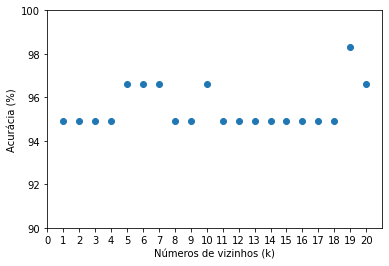

In [343]:
#Plot da acurácia por número de vizinhos
x_plot = range(1,21)
plt.scatter(x_plot,k_plot)
plt.ylabel("Acurácia (%)")
plt.xlabel("Números de vizinhos (k)")
plt.xticks(np.arange(0, 21, step=1));
plt.xlim(0, 21)
plt.ylim(90, 100)
plt.show()

In [344]:
print(max(k_plot))

98.30508474576271


#### II. Para diferentes p-normas

In [345]:
#Eixos do plot a ser montado
p_plot = list()
tp_plot = list()

start = time.perf_counter()

#Aplicamos o KNN para cada ponto do dataset de teste
for item in list(range(20)):
    yknn_k = list()
    buff = 0.0
    for datapoint in X_test.iterrows():
        buff = KNN(X_train, data['target'], datapoint[1], 4, item + 1)
        yknn_k.append(buff)
    y_buff = 100*(yknn_k==y_test).value_counts()/len(y_test)
    p_plot.append(y_buff[1])
end = time.perf_counter()
print(end-start)

53.839380000004894


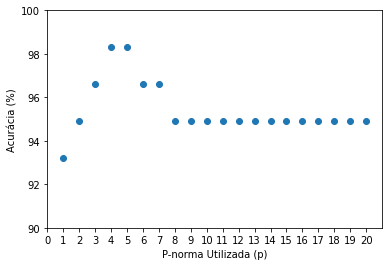

In [346]:
plt.scatter(x_plot,p_plot)
plt.ylabel("Acurácia (%)")
plt.xlabel("P-norma Utilizada (p)")
plt.xticks(np.arange(0, 21, step=1));
plt.xlim(0, 21)
plt.ylim(90, 100)
plt.show()

Para várias execuções, nos parece que $k = 5$ e $p = 5$ tem sido escolhas ótimas para a utilização do KNN.

In [347]:
yknn_k = list()
start = time.perf_counter()
for datapoint in X_test.iterrows():
    buff = KNN(X_train, data['target'], datapoint[1], 5,5)
    yknn_k.append(buff)
end = time.perf_counter()
print(end-start)
print(100*(yknn_k==y_test).value_counts()/len(y_test))

2.6297735999978613
True     98.305085
False     1.694915
Name: target, dtype: float64


### Par (k,p) que otimiza a acurácia 

Por completeza, plotamos a acurácia como uma função simultânea do número de vizinhos utilizado no KNN e a p-norma. Visto que o tempo de execução desta parte do notebook é grande, deixamos a rotina completamente comentada e mantivemos somente o gráfico com o resultado final encontrado.

In [348]:
#kp_matrix = list()

#start = time.perf_counter()

#Aplicamos o KNN para cada ponto do dataset de teste
#for item_p in list(range(20)):
#    k_line = list()
#    for item_k in list(range(20)):
#        yknn_k = list()
#        buff = 0.0
#        for datapoint in X_test.iterrows():
#            buff = KNN(X_train, data['target'], datapoint[1], item_k + 1, item_p + 1)
#            yknn_k.append(buff)
#        y_buff = 100*(yknn_k==y_test).value_counts()/len(y_test)
#        k_line.append(y_buff[1])
#    kp_matrix.append(k_line)
#end = time.perf_counter()
#print(end-start)

1065.486352299995


(0.5, 20.5)

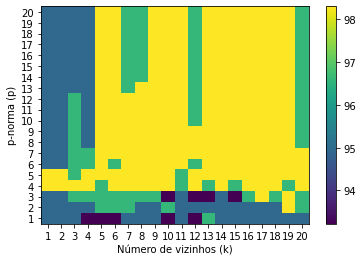

In [349]:
#x = range(1,21)
#y = range(1,21)
#Z = kp_matrix
#fig, ax = plt.subplots()
#contour = ax.pcolormesh(x, y, Z)

#plt.xticks(np.arange(1, 21, step=1));
#plt.yticks(np.arange(1, 21, step=1));
#plt.colorbar(contour)
#plt.ylabel("p-norma (p)")
#plt.xlabel("Número de vizinhos (k)")
#plt.xlim(0.5, 20.5)
#plt.ylim(0.5, 20.5)

### Comparação com sklearn

In [125]:
yknn_k = list()
start = time.perf_counter()
for datapoint in X_test.iterrows():
    buff = KNN(X_train, data['target'], datapoint[1], 5,1)
    yknn_k.append(buff)
end = time.perf_counter()
print(end-start)
print(100*(yknn_k==y_test).value_counts()/len(y_test))

1.8155743000006623
True     93.220339
False     6.779661
Name: target, dtype: float64


In [126]:
from sklearn.neighbors import KNeighborsClassifier
y_train = n_data_train['target']
start = time.perf_counter()
neigh = KNeighborsClassifier(n_neighbors=5, metric = 'manhattan')
neigh.fit(X_train, y_train)
end = time.perf_counter()
print(end-start)
print(100*(neigh.predict(X_test)==y_test).value_counts()/len(y_test))

0.0038313000004563946
True     93.220339
False     6.779661
Name: target, dtype: float64


Para uma mesma escolha de métrica (a Manhattan, p = 1), nossa acurácia é idêntica à do sklearn, mas em compensação a implementação do sklearn é muito mais otimizada do que a nossa, vencendo o tempo de execução por 3 ordens de grandeza. Notamos, no entanto, que a nossa utilização da p-norma permite uma melhoria na acurácia de até 5%.

## 3. Algoritmo PCA

Até o momento, temos aplicado o algoritmo KNN levando em consideração todas as features do dataset. Enquanto que para 13 features isso não resulta num custo computacional muito elevado, para datasets com milhares de features a computação do KNN se torna rapidamente intractável. 

Um método para reduzir o custo computacional de certos algoritmos - como o KNN - é utilizando-se o PCA (Análise de Componentes Principais). A ideia é que ao invés de computar as distâncias levando em consideração todas as 13 features do nosso dataset, nós podemos reduzir a dimensionalidade dos nossos dados, escolhendo os seus atributos principais. Isto é, os 'r' atributos (r < 13) que melhor determinam o comportamento do dataset como um todo. Isto reduz os dados de treino (e de teste) de uma matriz (178, 13) para uma matrix (178, r), reduzindo o custo computacional do nosso algoritmo.

### 3.1. Matriz de Covariância

No cabeçalho desta seção, mencionamos como o PCA nos dá uma forma de reduzir a dimensionalidade do nosso dataset, através das features 'dominantes'. Mas o que significa uma feature ser 'dominante'?

Se estamos pensando em termos probabilísticos, onde o valor de uma determinada feature de um determinado datapoint é uma variável aleatória, as features 'dominantes' serão aquelas cujos datapoints possuem a maior variância em torno do valor médio da feature. O motivo disto é evidente: se numa amostra de datapoints, uma determinada feature tem um valor aproximadamente idêntico para todos os datapoints (valor muito próximo da média/de variância pequena), então é certo de que esta feature não influenciará na classificação da amostra. No nosso caso, se todos os vinhos tivessem um atributo aproximadamente igual, uma amostragem aleatória deste feature não forneceria informação alguma para identificar se o vinho pertence à classe 0.0, 1.0 ou 2.0.

No outro extremo, features que possuem alta variância englobam bem mais o caráter geral do dataset e delimitam diferentes classificações de datapoints baseado em diferentes intervalos de valores de determinadas features. Concluímos, portanto, que as features mais relevantes do nosso dataset serão aquelas que têm a maior variância.

Para iniciar a nossa análise a respeito das features 'dominantes', calculamos a matriz de covariância do dataset ($C$):

\begin{equation}
C = X^T X
\end{equation}

Onde $X$ é nossa matriz de dados normalizada.

In [207]:
X_data = n_data.drop('target', axis = 'columns')
X_data_jax = jnp.array(X_data.values)
corr_n_data = np.matmul(X_data_jax.transpose(),X_data_jax)
print(corr_n_data.shape)

(13, 13)


Em datasets gerais, as features não são independentes umas das outras: diferentes pares de features podem determinar comportamentos diferentes do dataset e não são a rigor separáveis. No entanto, visto que matrizes de covariância são matrizes simétricas positivo-definidas, a álgebra linear nos diz que todos os autovalores desta matriz serão não-negativos. Isso significa que a diagonalização da matriz não só existe, mas de que os autovalores da matriz diagonal representarão as variâncias das 'direções independentes' do nosso dataset. Isto é, a diagonalização da matriz de covariância é equivalente a reescrevermos esta numa base cujas features são independentes umas das outras.

É como se tivéssemos, nesta nova base, uma matriz de covariância diagonal. Isto permite identificarmos as variâncias dominantes e, portanto, os comportamentos estatísticos dominantes do nosso dataset.

### 3.2. A Técnica SVD e sua relação com o PCA

Para diagonalizarmos a matriz de covariância, iremos utilizar o SVD (Decomposição em Valores Singulares). Toda matriz possui um SVD único, isto é, toda matriz pode ser decomposta na forma a seguir:

\begin{equation}
X = U \Sigma V^{T}
\end{equation}

Em que $U$ e $V$ são matrizes ortogonais e $\Sigma$ é uma matriz 'semi-diagonal': se a matriz $X$ for uma matrix $m\times n$ em que $m>n$, $\sigma$ será uma matriz $m\times n$ composta por uma matriz diagonal $m\times m$ e com o restante de suas entradas nulas.

De modo geral, poderíamos aplicar o SVD diretamente na matriz de dados. No entanto, isto seria uma medida excessiva: não estamos interessados na matriz ortogonal $U$ de dimensões (178, 178) no SVD do dataset. Isto é, nós estamos interessados nas correlações entre as diferentes features do nosso dataset e, portanto, na base de vetores ortonormais que diagonalizam a matriz de covariância (a matriz $V$, de dimensões (13,13)).

A relação disto com o PCA pode ser entendido da seguinte maneira:

\begin{equation}
C = X^T X = (U \Sigma V^{T})^T U \Sigma V^{T} = V \Sigma^T U^T U \Sigma V^{T} = V \Sigma^T \Sigma  V^{T} \equiv V D  V^{T} 
\end{equation}

Onde $X$ é a matriz do dataset de features normalizadas, $C$ é a matriz de covariância que havíamos mencionado anteriormente e $D$ é a matriz diagonal formada pelos autovalores da matriz $C$. Com isto, temos a matriz dos vetores ortonormais, as quais diagonalizam a matriz de covariância, e temos os autovalores da matriz de covariância, as quais representam a variância (o quadrado do desvio padrão) de cada uma das features independentes do nosso dataset.

Através da matriz ortogonal $V$, ordenada em termos dos autovalores da matriz de covariância, conseguimos reescrever a nossa matriz de dados em termos das suas 'componentes principais'. O PCA, então, está diretamente relacionado com a projeção da nossa matriz de dados sobre a base que diagonaliza a matriz de covariância:

\begin{equation}
\text{PCA}(A) = \text{Proj}_{V}(A) = A V
\end{equation}

In [350]:
#SVD da matriz de covariância
corr_n_data_svd = jnp.linalg.svd(corr_n_data)

#Projeção da matriz de dados na base de autovetores da matriz de covariância
X_data_princ = jnp.matmul(X_data_jax, corr_n_data_svd[0])
print(X_data_princ.shape)

(178, 13)


### 3.3. Acurácia do KNN para diferentes escolhas de base

O propósito do PCA é reduzir a dimensionalidade dos nossos dados, em particular, priorizando as dimensões de maior variância dos nossos dados, em acordo com a discussão anterior. Para provar a utilidade desta técnica, vamos testar a acurácia do KNN para diferentes escolhas de base. Isto é, vamos comparar a acurácia do KNN utilizando os últimos 4 componentes e depois os primeiros 4 componentes.

#### Últimas 4 componentes

In [351]:
#4 últimas componentes dos dados
X_princ_final_4 = X_data_princ[:,-4:]
n_data_princ_final_4 = pd.DataFrame(data = np.c_[X_princ_final_4, n_data['target']], columns= ['PCA10', 'PCA11', 'PCA12', 'PCA13'] + ['target'])
#print(n_data_princ_final_4)

#Dados de treino e teste reduzidos
n_train_final_4 = n_data_princ_final_4.head(train_size)
n_test_final_4 = n_data_princ_final_4.tail(test_size)

#Divisão entre X e y
X_train_final_4 = n_train_final_4.drop('target', axis = 'columns')
X_test_final_4 = n_test_final_4.drop('target', axis = 'columns')
y_full_final_4 = n_data_princ_final_4['target']
y_test_final_4 = n_test_final_4['target']

In [352]:
#KNN com k = 5, p = 5
yknn_k = list()
start = time.perf_counter()
for datapoint in X_test_final_4.iterrows():
    buff = KNN(X_train_final_4, y_full_final_4, datapoint[1], 5,5)
    yknn_k.append(buff)
end = time.perf_counter()
print(end-start)
print(100*(yknn_k==y_test_final_4).value_counts()/len(y_test_final_4))

3.0859597000089707
True     50.847458
False    49.152542
Name: target, dtype: float64


#### Primeiras 4 componentes

In [353]:
#4 primeiros componentes dos dados
X_princ_first_4 = X_data_princ[:,:4]
n_data_princ_first_4 = pd.DataFrame(data = np.c_[X_princ_first_4, n_data['target']], columns= ['PCA1', 'PCA2', 'PCA3', 'PCA4'] + ['target'])
#print(n_data_princ_first_4)

#Dados de treino e teste reduzidos
n_train_first_4 = n_data_princ_first_4.head(train_size)
n_test_first_4 = n_data_princ_first_4.tail(test_size)

#Divisão entre X e y
X_train_first_4 = n_train_first_4.drop('target', axis = 'columns')
X_test_first_4 = n_test_first_4.drop('target', axis = 'columns')
y_full_first_4 = n_data_princ_first_4['target']
y_test_first_4 = n_test_first_4['target']

In [354]:
#KNN com k = 5, p = 5
yknn_k = list()
start = time.perf_counter()
for datapoint in X_test_first_4.iterrows():
    buff = KNN(X_train_first_4, y_full_first_4, datapoint[1], 5,5)
    yknn_k.append(buff)
end = time.perf_counter()
print(end-start)
print(100*(yknn_k==y_test_first_4).value_counts()/len(y_test_first_4))

2.9606715999980224
True     93.220339
False     6.779661
Name: target, dtype: float64


#### Conclusão

Vemos, então, que existe uma diferença de acurácia significativa entre a base formada pelos últimos 4 autovetores - ou seja, os relacionados aos menores 4 autovalores da matriz de covariância - e a base formada pelos primeiros 4 autovetores, os quais estão relacionados aos maiores autovalores (para várias execuções do notebook, encontramos uma diferença de mais do que 40%). Além disso, a acurácia do KNN para as primeiras componentes é próxima do KNN onde consideramos todas as 13 features.

### 3.4. Implementação do PCA

Sabendo que as componentes relacionadas aos maiores autovalores da matriz de covariância retém a maior quantidade de informação do nosso dataset original, iremos finalmente implementar a a função PCA, a qual tomará como input uma matriz de dados (normalizada) e um número inteiro, este o qual quantificará o número de componentes da base da matriz de covariância que serão selecionados para a representação reduzida dos dados, começando dos autovetores de maiores autovalores aos menores. O output, então, será a projeção dos dados sobre as componentes principais.

In [355]:
def PCA(data, num_components):

    #Transforma pd.DataFrame em matriz do jax
    data_buff = jnp.array(data)

    #Calcula a matriz de covariância
    corr_data = jnp.matmul(data_buff.transpose(),data_buff)

    #Calcula o SVD da matriz de covariância
    corr_data_svd = jnp.linalg.svd(corr_data)

    #Projeta os dados na base dos autovetores da matriz de covariância, as colunas estando em ordem crescente de autovalores
    data_princ = jnp.matmul(data_buff, corr_data_svd[0])

    #Seleciona as 'num_components' componentes principais dos dados
    data_PCA = data_princ[:,:num_components]

    #Rotina para gerar os nomes das colunas do PCA, para quando convertermos tudo de volta a um pd.DataFrame
    column_names = list()
    i=0
    while i < num_components:
        name = 'PCA' + str(i+1)
        column_names.append(name)
        i+=1

    #Conversão da matriz JAX para pd.DataFrame, nomeando as features principais em termos do PCA
    data_PCA_df = pd.DataFrame(pd.DataFrame(data = np.c_[data_PCA], columns= column_names))
    return data_PCA_df

In [356]:
print(PCA(X_data, 4))

         PCA1      PCA2      PCA3      PCA4
0   -0.376150  1.027045 -1.794466  0.978544
1   -2.050261  1.925034  0.007369  0.721323
2   -2.248507  1.884593  2.031841  1.407630
3    0.462335  0.618288 -0.483443  3.576724
4   -3.214918 -0.166992  1.973572  1.120684
..        ...       ...       ...       ...
173  3.677919 -0.847750  1.339420 -0.125174
174  0.107228  1.928923 -0.690148 -0.273725
175 -2.677412 -1.471873  0.332262 -0.349354
176 -3.124403 -0.786897  0.364887 -0.025564
177 -3.458157 -1.130629  1.204277  0.162463

[178 rows x 4 columns]


### 3.5. Acurácia e Tempo Médio de Execução em função das Componentes

Para encerrar o notebook, vamos agora comparar os tempos de execução da rotina para diferentes números de componentes, para ver se observamos alguma diferença notável. Para calcular o tempo de execução médio, utilizamos 100 repetições da rotina. Assim como no cálculo do gráfico de acurácia como função do par (k,p), deixamos esta rotina completamente comentada e somente exibimos os resultados finais que foram obtidos.

In [357]:
#Eixo y do plot a ser montado
#t_plot = list()
#acc_plot = list()

#Número de execuções do KNN para realizarmos a média
#reps = 100

#start = time.perf_counter()

#Aplicamos o KNN para cada ponto do dataset de teste
#for num_comp in list(range(1,14)):
    
    #KNN para o número de componentes escolhido. No 'for', o número de execuções total para a medida do tempo
#    start_knn = time.perf_counter()

    #Repetições para realizar a média temporal
#    for item in range(reps):
        
        #Definição de dados de teste e treino, conforme a escolha de PCA
#        X_PCA = PCA(X_data, num_comp)
#        X_train_PCA = X_PCA.head(train_size)
#        X_test_PCA = X_PCA.tail(test_size)

        #Início de fato do KNN
#        yknn_k = list()
#        buff = 0.0
#        for datapoint in X_test_PCA.iterrows():
#            buff = KNN(X_train_PCA, n_data['target'], datapoint[1], 5, 5)
#            yknn_k.append(buff)
#        y_buff = 100*(yknn_k==y_test).value_counts()/len(y_test)

        #Como a medida da acurácia não varia com as repetições do código (depende somente do número de componentes do PCA) rodamos esta parte somente
        #uma vez
#        if item == 0:
#            acc_plot.append(y_buff[1])
#    end_knn = time.perf_counter()
    
    #Cálculo do tempo de execução médio
#    time_knn=(end_knn-start_knn)/reps
#    t_plot.append(time_knn)

#end = time.perf_counter()
#print(end-start)

3299.38907569999


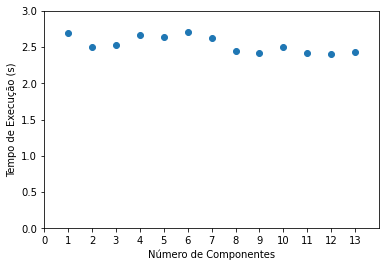

In [359]:
#plt.scatter(range(1,14), t_plot)
#plt.ylabel("Tempo de Execução (s)")
#plt.xlabel("Número de Componentes")
#plt.xticks(np.arange(0, 14, step=1));
#plt.xlim(0, 14)
#plt.ylim(0.0,3.0)
#plt.show()

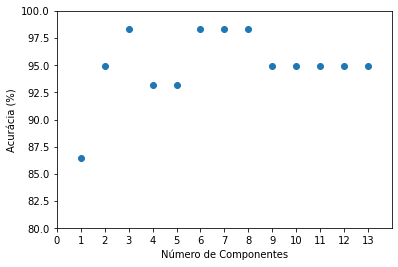

In [358]:
plt.scatter(range(1,14), acc_plot)
plt.ylabel("Acurácia (%)")
plt.xlabel("Número de Componentes")
plt.xticks(np.arange(0, 14, step=1));
plt.xlim(0, 14)
plt.ylim(80,100)
plt.show()

#### Conclusão

Em função da forma não-otimizada em que definimos as rotinas do KNN, o tempo de execução tem sido aproximadamente independente do número de componentes do PCA. Já a respeito da acurácia, vemos que até mesmo para uma única componente, conseguimos uma acurácia acima de 80% na aplicação do KNN. 